In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbAgg')
import scipy as scipy
import seaborn as sns
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from tabulate import tabulate
np.set_printoptions(threshold=np.inf)
sns.set_theme(context='paper', style='white', palette='colorblind',font='Helvetica')

In [2]:
#downloading stored arrays 
%store -r EDML_RRM
%store -r EDML_RRMAD
%store -r EDML_sulfate
%store -r EDML_age
%store -r EDML_depth
%store -r EDML_thickness
%store -r EDML_thinning_corr
%store -r EDML_depth_th

#EDML_RRMAD = EDML_RRMAD[:len(EDML_sulfate)] #just making sure we are using first part of array before interpolation
#EDML_sulfate = EDML_sulfate[:-1]
##EDML_RRM = EDML_RRM[:-1]
#EDML_age = EDML_age[:-1]
#EDML_depth = np.copy(EDML_depth_th)
EDML_RRM = np.array(EDML_RRM)

len(EDML_sulfate), len(EDML_depth), len(EDML_RRM)

(67540, 67540, 100283)

In [3]:
#downloading execlfiles with conductivity
excel_1 = pd.ExcelFile('EDML_CFA_on_GICC05_A.xls')
A = pd.read_excel(excel_1, 'Sheet1')
A = np.array(A)
excel_2 = pd.ExcelFile('EDML_CFA_on_GICC05_B.xls')
B = pd.read_excel(excel_2, 'Sheet1')
B = np.array(B)
excel_3 = pd.ExcelFile('EDML_CFA_on_GICC05_C.xls')
C = pd.read_excel(excel_3, 'Sheet1')
C = np.array(C)

In [4]:
depth_A = A[:,0]
cond_A = A[:,5]
age_A = A[:,6]
depth_B = B[:,0]
cond_B = B[:,5]
age_B = B[:,6]
depth_C = C[:,0]
cond_C = C[:,5]
age_C = C[:,6]

depth = np.concatenate((depth_A,depth_B,depth_C), axis=None)
cond = np.concatenate((cond_A,cond_B,cond_C), axis=None)
age = np.concatenate((age_A,age_B,age_C), axis=None)

cond[cond==np.nan]

array([], dtype=float64)

In [5]:
#%matplotlib qt5
#fig, axs = plt.subplots(2, sharex=True)
#ax2 = plt.twinx()
#axs[0].plot(depth, cond, '-')
#axs[1].plot(EDML_depth, EDML_sulfate, '-', color= 'm')
#axs[1].plot(EDML_depth, EDML_RRMAD[:-1], '-', color='r')

#plt.show()

EDML_RRMAD = EDML_RRMAD[:67540]

len(EDML_sulfate),len(EDML_RRMAD)

(67540, 67540)

In [6]:
peaks = []
depth_peaks = []

for i in range(len(EDML_RRMAD)):
    if EDML_sulfate[i] > EDML_RRMAD[i]:
        peaks.append(EDML_sulfate[i])
        depth_peaks.append(EDML_depth[i])

In [7]:
cond_interp = np.interp(depth_peaks, depth, cond)
peaks = np.array(peaks)
depth_peaks = np.array(depth_peaks)

peaks = peaks[~np.isnan(cond_interp)]
depth_peaks = depth_peaks[~np.isnan(cond_interp)]
cond_interp = cond_interp[~np.isnan(cond_interp)]

peaks = peaks.reshape(len(peaks,))

np.shape(peaks), np.shape(depth_peaks),  np.shape(cond_interp)

((10910,), (10910,), (10910,))

In [8]:
depth_peaks = depth_peaks[peaks < 2000]
cond_interp= cond_interp[peaks < 2000]
peaks = peaks[peaks < 2000]

corr = pearsonr(np.nan_to_num(cond_interp), np.nan_to_num(peaks))

corr

(0.71908356908603, 0.0)

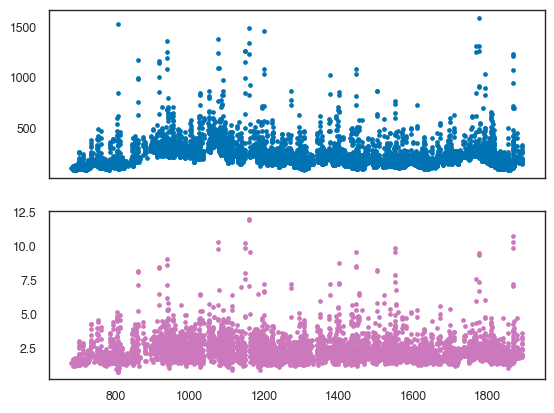

In [9]:
%matplotlib inline
fig, axs = plt.subplots(2, sharex=True)
#ax2 = plt.twinx()
axs[0].plot(depth_peaks, peaks, '.')
axs[1].plot(depth_peaks, cond_interp, '.', color= 'm')

plt.show()
#ax1.set_ylim(-100,3600)


In [10]:
cond_interp = np.nan_to_num(cond_interp)
peaks = np.nan_to_num(peaks)

cond_interp = cond_interp.reshape((-1,1))
peaks = peaks.reshape((-1,1))

#peaks[cond_interp == 0] = 0

model = LinearRegression().fit(cond_interp , peaks)
r_sq = model.score(cond_interp, peaks)

x = np.arange(0, np.nanmax(cond_interp)+1,1)
y = x * model.coef_ + model.intercept_
y = y.reshape((14,))

print("k=",model.coef_[0][0],"m=", model.intercept_[0],"r_sq=", r_sq, EDML_depth[-1], depth[-1], 'p-value', model)

k= 107.96002697697928 m= -24.298247242317046 r_sq= 0.5170811793295038 1892.9826690909088 2349.99 p-value LinearRegression()


Text(0.03, 0.92, 'EDML')

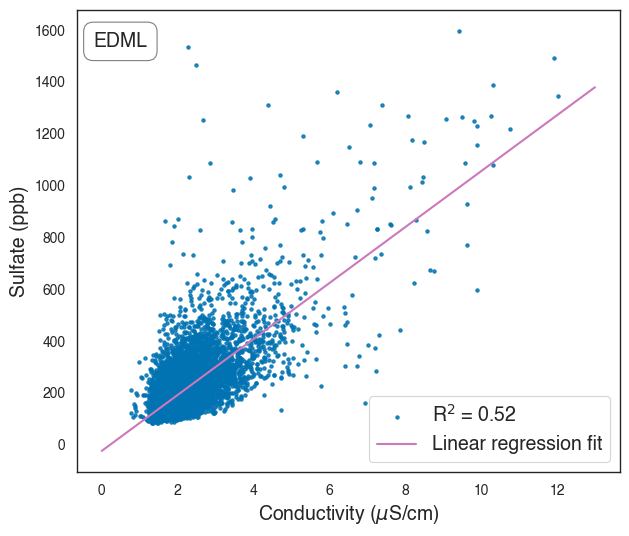

In [11]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.scatter(cond_interp,peaks, marker='.', label = f'R$^2$ = {np.round(r_sq,2)}' , alpha=0.85)
ax.plot(x , y, 'm', linewidth=1.5, label='Linear regression fit')
ax.set_xlabel(r'Conductivity ($\mu$S/cm)', fontsize = 14)
ax.set_ylabel('Sulfate (ppb)', fontsize = 14)
ax.legend(fontsize=14, ncol=1, loc='lower right')
ax.tick_params(axis='both', labelsize=10)
plt.text(0.03, 0.92, 'EDML',  transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round', pad=.5, alpha=1))
#plt.savefig('/Users/feliciacarlborg/Documents/Master thesis /Pictures/Sul_cond_corr_2.jpg')

In [12]:
depth_rest = depth[depth > EDML_depth[-1]]
age_rest = age[depth > EDML_depth[-1]]
cond_rest = cond[depth > EDML_depth[-1]]

sulfate_rest =  model.intercept_[0] + cond_rest * model.coef_[0][0]

EDML_depth_all = np.concatenate((EDML_depth, depth_rest), axis=None)
EDML_age_all = np.concatenate((EDML_age, age_rest), axis=None)
EDML_sulfate_all = np.concatenate((EDML_sulfate, sulfate_rest), axis=None)

%store EDML_depth_all
%store EDML_age_all
%store EDML_sulfate_all

print(model.intercept_[0])


Stored 'EDML_depth_all' (ndarray)
Stored 'EDML_age_all' (ndarray)
Stored 'EDML_sulfate_all' (ndarray)
-24.298247242317046


Text(0.03, 0.92, 'EDML')

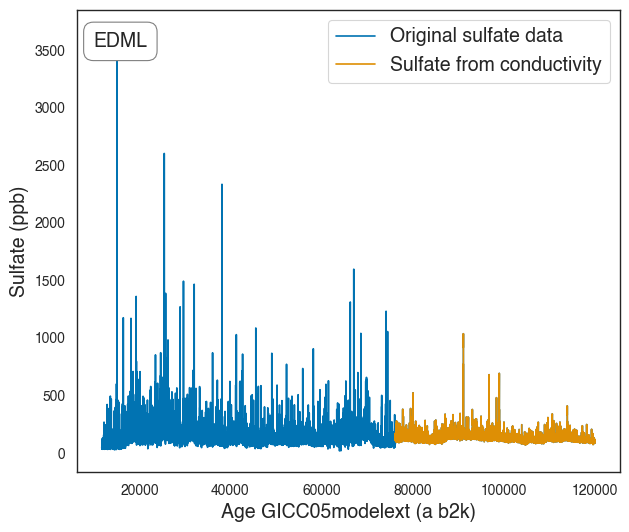

In [14]:
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.plot(EDML_age_all[~np.isnan(EDML_age_all)], EDML_sulfate_all[~np.isnan(EDML_age_all)], label= 'Original sulfate data')
ax.plot(age_rest, sulfate_rest, label= 'Sulfate from conductivity')
#plt.plot(EDML_age_all[~np.isnan(EDML_age_all)], EDML_RRM, label = 'RRM')
ax.set_xlabel('Age GICC05modelext (a b2k)', fontsize=14)
ax.set_ylabel('Sulfate (ppb)', fontsize=14)
ax.legend(fontsize=14, ncol=1, loc='upper right')
ax.tick_params(axis='both', labelsize=10)
plt.text(0.03, 0.92, 'EDML',  transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='White', edgecolor='grey', boxstyle='round', pad=.5, alpha=1))
